In [161]:
import numpy as np
import pandas as pd

import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy.contrasts import Diff

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# Formulas

Uses [patsy](https://patsy.readthedocs.io/en/latest/formulas.html)

* (~) Separates the left-hand side and right-hand side of a formula. Optional. If not present, then the formula is considered to contain a right-hand side only.
* (+) Takes the set of terms given on the left and the set of terms given on the right, and returns a set of terms that combines both (i.e., it computes a set union). Note that this means that a + a is just a.
* (-) Takes the set of terms given on the left and removes any terms which are given on the right (i.e., it computes a set difference).
* (\*) a \* b is short-hand for a + b + a:b, and is useful for the common case of wanting to include all interactions between a set of variables while partitioning their variance between lower- and higher-order interactions. (Standard ANOVA models are of the form a \* b \* c \* ....)


# Example Dataset

The "mtcars" data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973–74 models).


data has 32 observations on 11 (numeric) variables.

* mpg	- Miles/(US) gallon
* cyl	- Number of cylinders
* disp	- Displacement (cu.in.)
* hp	- Gross horsepower
* drat	- Rear axle ratio
* wt	- Weight (1000 lbs)
* qsec	- 1/4 mile time
* vs	- Engine (0 = V-shaped, 1 = straight)
* am	- Transmission (0 = automatic, 1 = manual)
* gear	- Number of forward gears
* carb	- Number of carburetors

First, import the data.

In [24]:
mtcars = sm.datasets.get_rdataset("mtcars", "datasets", cache=True).data
mtcars.head(10)


,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


We want to see if the miles per gallon $(mpg)$ of each car changes by the weight $(wt)$ and by the cylinders $(cyl)$ of the engine. We will explore these relationships using OLS regression but we should first visualize the relationship.


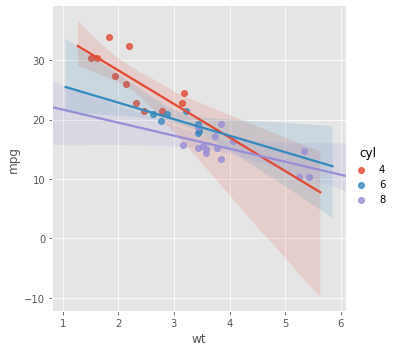

In [107]:

sns.lmplot(x='wt', y='mpg', hue='cyl' ,data = mtcars)
plt.show()

Now we want to transfer our hypothesis about the relationship between the "response variable" mpg and the covariates wt and cyl. This equation can be written as:

$$mpg=\beta_{0}+\beta_{1}wt+\beta_{2}cyl$$

Using the formula components described in [patsy](https://patsy.readthedocs.io/en/latest/formulas.html) we write the following formula:


In [163]:
fml = 'mpg ~ wt + cyl'
fml

'mpg ~ wt + cyl'

Now using statsmodel's ols implementation we will fit our model to the data.

In [165]:
md = smf.ols(fml, mtcars)
mdf = md.fit()

First we should visualize the residuals.

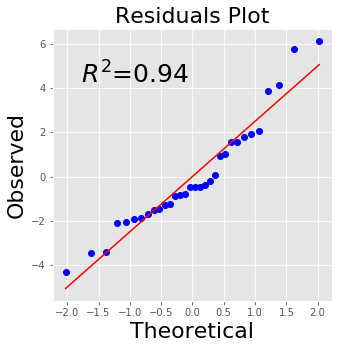

In [166]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

_, (__, ___, r) = sp.stats.probplot(mdf.resid, plot=ax, fit=True)
ax.annotate('$R^{2}$=%.2f'%(r**2), (.1,.8), fontsize=25
            ,xycoords = 'axes fraction')
ax.set_title('Residuals Plot',
             fontsize=22)
ax.set_xlabel('Theoretical',
             fontsize=22,
              c='black')
ax.set_ylabel('Observed',
              fontsize=22,
              c='black')
plt.show()

The $R^{2}$ value looks good so now we should explore the other measures of model quality.

In [167]:
mdf.summary().tables[0]

Dep. Variable:,mpg,R-squared:,0.830
Model:,OLS,Adj. R-squared:,0.819
Method:,Least Squares,F-statistic:,70.91
Date:,"Tue, 15 Oct 2019",Prob (F-statistic):,6.81e-12
Time:,13:56:59,Log-Likelihood:,-74.005
No. Observations:,32,AIC:,154.0
Df Residuals:,29,BIC:,158.4
Df Model:,2,,
Covariance Type:,nonrobust,,


The model seems to have fit well, so now we can explore the results.

In [112]:
mdf.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,39.6863,1.715,23.141,0.000,36.179,43.194
wt,-3.1910,0.757,-4.216,0.000,-4.739,-1.643
cyl,-1.5078,0.415,-3.636,0.001,-2.356,-0.660


Given the coefficients of the model we can rewrite our initial formula as 

$$mpg=39.68-3.19wt-1.5cyl$$

The coefficients of the model can be read as follows:

For every unit cyl increase, with weight being constant the mpg increases by ~1.5
For every unit wt increase, with cyl being constant the mpg increases by ~3.19
    
If we had a car with zero weight and zero cyl we would expect it to have ~40 mpg -- which does not make much sense.

We also note that the coefficients for wt and cyl have significant p-values (at the common alpha level of 0.05). 
Thus in both cases we reject the null hypothesis.

This all seems great but what if we think there is an interaction between the weight and cyl terms. 

By saying these terms are interacting we mean that we believe the relationship between weight and mpg is different for varying cyl.

In order to add this interaction term we use `:` or `*` both can be use equivalently in the following:

```python
"mpg ~ wt + cyl + wt:cyl"
```

is the same as 

```python
"mpg ~ wt * cyl"
```

which mathematically gives us the formula:

$$mpg=\beta_{0}+\beta_{1}wt+\beta_{2}cyl+\beta_{3}\,wt\,cyl$$

Personally, I like to write it long hand as:

In [168]:
fml = "mpg ~ wt + cyl + wt:cyl"
fml

'mpg ~ wt + cyl + wt:cyl'

Now we will fit the model with the new formula and explore the model fit the same as above.

In [169]:
md = smf.ols(fml, mtcars)
mdf = md.fit()

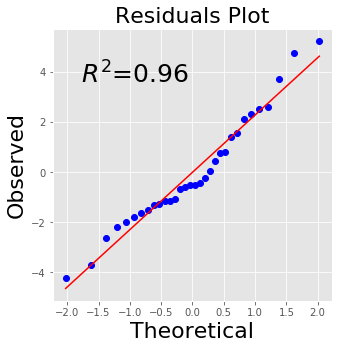

In [170]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

_, (__, ___, r) = sp.stats.probplot(mdf.resid, plot=ax, fit=True)
ax.annotate('$R^{2}$=%.2f'%(r**2), (.1,.8), fontsize=25
            ,xycoords = 'axes fraction')
ax.set_title('Residuals Plot',
             fontsize=22)
ax.set_xlabel('Theoretical',
             fontsize=22,
              c='black')
ax.set_ylabel('Observed',
              fontsize=22,
              c='black')
plt.show()

In [171]:
mdf.summary().tables[0]

Dep. Variable:,mpg,R-squared:,0.861
Model:,OLS,Adj. R-squared:,0.846
Method:,Least Squares,F-statistic:,57.62
Date:,"Tue, 15 Oct 2019",Prob (F-statistic):,4.23e-12
Time:,14:00:12,Log-Likelihood:,-70.852
No. Observations:,32,AIC:,149.7
Df Residuals:,28,BIC:,155.6
Df Model:,3,,
Covariance Type:,nonrobust,,


Our model fit improved significantly -- this is our first sign that we are on to something. Let's look at the model results (Note: we will now have a new interaction term called `wt:cyl`).

In [143]:
mdf.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,54.3068,6.128,8.863,0.000,41.755,66.858
wt,-8.6556,2.320,-3.731,0.001,-13.408,-3.903
cyl,-3.8032,1.005,-3.784,0.001,-5.862,-1.745
wt:cyl,0.8084,0.327,2.470,0.020,0.138,1.479


n contrast to the previous formulation, our new formulation (using the equation above) is:

$$mpg=54.306-8.6556 wt-3.8032\,cyl+0.8084\,wt\,cyl$$

Turning this into statements we say:

For a unit increase in weight, with zero cyl, mpg decreases by 8.6556

For a unit increase in cyl, with zero weight, mpg decreases by 3.8032

For the interaction terms we say:

For a unit increase in weight, mpg changes by -8.6556 + 0.8084 cyl

For a unit increase in cyl, mpg changes by -3.8032 + 0.8084 wt


We also note that the interaction coef for wt and cyl have significant p-values. Therefore we need to visualize this interaction. 


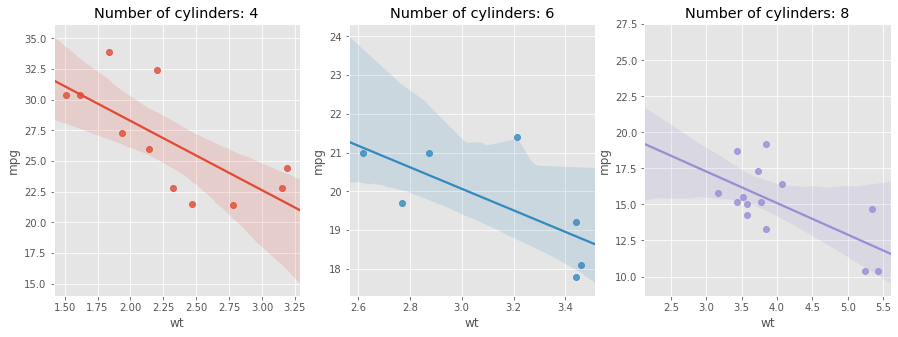

In [144]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

for ax, (pk,pdf) in zip(ax.flatten(), mtcars.groupby('cyl')):

    sns.regplot(x='wt', y='mpg', data = pdf, ax=ax)
    ax.set_title('Number of cylinders: %i'%(pk))

plt.show()

From these plots it seems that mpg vs. wt has a stronger relationship in 4 cyl than in 6 and 8.

If we want to explicitly separate each cylinder out we need to use a Diff formula. This can be written as:

```python
"mpg ~ wt + C(cyl, Diff, levels=[6, 8, 4]) + wt:C(cyl, Diff, levels=[6, 8, 4])"
```

This will compare 6 cyl to 4 cyl and then 8 cyl to 4 cyl.

In [172]:
fml = "mpg ~ wt + C(cyl, Diff, levels=[6, 8, 4]) + wt:C(cyl, Diff, levels=[6, 8, 4])"
fml

'mpg ~ wt + C(cyl, Diff, levels=[6, 8, 4]) + wt:C(cyl, Diff, levels=[6, 8, 4])'

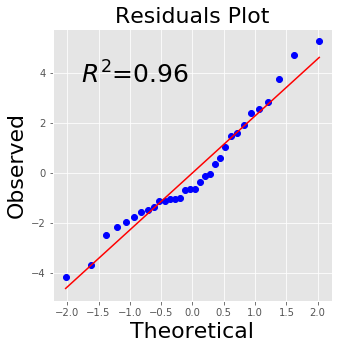

In [173]:
md = smf.ols(fml, mtcars)
mdf = md.fit()

fig, ax = plt.subplots(1,1,figsize=(5,5))

_, (__, ___, r) = sp.stats.probplot(mdf.resid, plot=ax, fit=True)
ax.annotate('$R^{2}$=%.2f'%(r**2), (.1,.8), fontsize=25
            ,xycoords = 'axes fraction')
ax.set_title('Residuals Plot',
             fontsize=22)
ax.set_xlabel('Theoretical',
             fontsize=22,
              c='black')
ax.set_ylabel('Observed',
              fontsize=22,
              c='black')
plt.show()

In [174]:
mdf.summary().tables[0]

Dep. Variable:,mpg,R-squared:,0.862
Model:,OLS,Adj. R-squared:,0.835
Method:,Least Squares,F-statistic:,32.36
Date:,"Tue, 15 Oct 2019",Prob (F-statistic):,2.26e-10
Time:,14:11:04,Log-Likelihood:,-70.741
No. Observations:,32,AIC:,153.5
Df Residuals:,26,BIC:,162.3
Df Model:,5,,
Covariance Type:,nonrobust,,


In [160]:
mdf.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6160,3.346,9.151,0.000,23.739,37.493
"C(cyl, Diff, levels=[6, 8, 4])[D.6]",-4.5408,9.515,-0.477,0.637,-24.100,15.018
"C(cyl, Diff, levels=[6, 8, 4])[D.8]",15.7032,4.839,3.245,0.003,5.756,25.651
wt,-3.5399,1.081,-3.275,0.003,-5.762,-1.318
"wt:C(cyl, Diff, levels=[6, 8, 4])[D.6]",0.5877,2.944,0.200,0.843,-5.465,6.640
"wt:C(cyl, Diff, levels=[6, 8, 4])[D.8]",-3.4546,1.627,-2.123,0.043,-6.799,-0.110


From both the plot and these results we see that the 8 cyl is significantly different from 4 cyl by mpg and in the interaction of weight and mpg. However 6 cyl is not significant in either comparison.